In [1]:
%reset -f

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import math as math
from scipy.integrate import solve_ivp
from scipy.integrate import quad 
import scipy.optimize as optimize 

#df_Me = pd.read_excel(r'/Users/caterina/Documents/TU:e/CPT/Process Tech/python intro/Cp_methanol.xlsx')
#df_Iso = pd.read_excel(r'/Users/caterina/Documents/TU:e/CPT/Process Tech/python intro/Cp_isopropanol.xlsx')


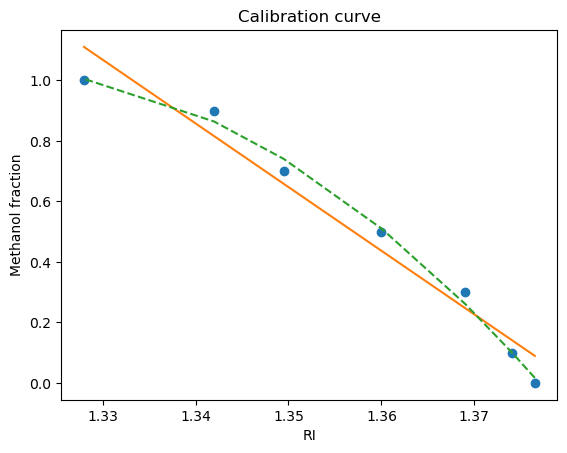

0.5105995532411498


In [3]:
# Refractive Index Calibration Curve

#Measurements
Me_fraction = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
RI = [1.3765, 1.374, 1.369, 1.360, 1.3495, 1.342, 1.328]

#fitting line at multiple degrees
Cal_a_fit, Cal_b_fit = np.polyfit(RI, Me_fraction, deg=1)
Cal_a_fit2, Cal_b_fit2, Cal_c_fit2 = np.polyfit(RI, Me_fraction, deg=2)

plt.plot(RI, Me_fraction,"o")
plt.plot(RI, np.polyval((Cal_a_fit, Cal_b_fit), RI),"-")
plt.plot(RI, np.polyval((Cal_a_fit2, Cal_b_fit2, Cal_c_fit2), RI), "--")
plt.xlabel("RI")
plt.ylabel("Methanol fraction")
plt.title('Calibration curve')
plt.show()

def Calibration(RI):
    Me_ratio = RI**2 * Cal_a_fit2 + RI*Cal_b_fit2 + Cal_c_fit2
    return Me_ratio

#use calibration function to get the methanol fraction
Me_frac = Calibration(1.36)
print(Me_frac)

In [4]:
#Constants 

R = 8.3144598    # Gas constant J/molK
g = 9.807        # Gravitational acceleration m/s^2

# Reboiler info and trey
A_r = 0.08                  # Evaporation surface area m2
dH_vap_Me = 37340        # Enthalpy of vaporisation methanol at boiling point [J/mol]
dH_vap_iso = 44000
eff = 1 #640/751         # Heater efficiency (around 0.85)
T0 = 298                 #K
V  = 0.01                # Volume of mixture in reboiler [m^3]
Iso_frac = 1-Me_frac     # Mole fraction isopropanol
dens_Me = 792        #g/dm3
dens_Iso = 786       #g/dm3
dens_gas_Me = 0.9112 #g/dm3
M_Me = 32.02             #g/mol
M_Iso = 60.1             #g/mol
Vm_Me = 40.75            # molar volume methanol [cm^3/mol]
Vm = (M_Me/1000/dens_Me)*Me_frac + (M_Iso/1000/dens_Iso)*(1-Me_frac) # Molar volume of mixture [m^3/mol]
n_total = V/Vm           # Total number of moles in mixture
n_Me = Me_frac*n_total   # Number of moles of methanol
n_Iso = Iso_frac*n_total # Number of moles of isopropanol
power_percent = 0.7
power = eff*power_percent*2000   #J/s (maximum power is 2kW)
A_tray = 0.001963495408493621   #surface area of one tray in m2
lw =  0.025                      #length weir in m 
#A_weir = 
How = 0.005                      #height over outlet weir in m  
dp = 547.7                       #pressure drop over entire column in Pa
x_iso_in = 0.5                   #Isopropanol fraction inlet
x_me_in = 0.5                    #Methanol fraction inlet
RR = 0.2                         #Reflux ratio

In [5]:
#Heat transfer coefficients 

Cp_L_me = 87.71   #J/mol.K
Cp_v_me = 47.99   #J/mol.K
Cp_L_iso = 176.16 #J/mol.K
Cp_v_iso = 110.29 #J/mol.K

#Heat transfer coefficients 

Cp_L_me = 87.71   #J/mol.K
Cp_v_me = 47.99   #J/mol.K
Cp_L_iso = 176.16 #J/mol.K
Cp_v_iso = 110.29 #J/mol.K

#Total liquid avg heat transfer coeff in J/mol.K
def Cp_L(x_me, x_iso):
    Cp_L = x_me*Cp_L_me + x_iso*Cp_L_iso
    return Cp_L

#Total vapor avg heat transfer coeff in J/mol.K
def Cp_v(y_me, y_iso):
    Cp_v = y_me*Cp_v_me + y_iso*Cp_v_iso
    return Cp_v

#Total (liquid+vapor) avg heat transfer coeff in J/mol.K
def Cp_tot(Nme_L,Niso_L,Nme_v,Niso_v):
    x_me = Nme_L/(Nme_L+Niso_L+Nme_v+Niso_v)
    x_iso = Niso_L/(Nme_L+Niso_L+Nme_v+Niso_v)
    y_me = Nme_v/(Nme_L+Niso_L+Nme_v+Niso_v)
    y_iso = Niso_v/(Nme_L+Niso_L+Nme_v+Niso_v)
    Cp_tot = x_me*Cp_L_me + x_iso*Cp_L_iso + y_me*Cp_v_me + y_iso*Cp_v_iso
    return Cp_tot


# Vapor pressure for both compounds in Pa 
def p0_me(T):
    #Antonie constants-methanol 
    A_me = 8.08097
    B_me = 1582.27
    C_me = 239.7
    #vapour pressure
    anto_me = A_me - (B_me/(T+C_me))
    p0_me_mmHg = math.pow(10,anto_me) 
    p0_me = p0_me_mmHg/0.00750062   #Pa

    return p0_me   


def p0_iso(T):
    #Antoine constants isopropanol
    A_iso = 8.00308
    B_iso =	1505.52
    C_iso = 211.6
    #vapour pressure 
    anto_iso = A_iso - (B_iso/(T+C_iso))
    p0_iso_mmHg = math.pow(10,anto_iso)
    p0_iso = p0_iso_mmHg/0.00750062   #Pa
    
    return p0_iso

def BP_mix(x_me,x_iso):
    BP_me = 64.7+273.15
    BP_iso = 82.3+273.15
    BP_mix = x_me*BP_me + x_iso*BP_iso
    return BP_mix

def dens_L(x_me,x_iso):
    dens_L = x_me*dens_Me + x_iso*dens_Iso
    return dens_L


In [6]:
k_me = 1.34  #m/s 
k_iso = 1.27 #m/s


In [7]:
params = {
    'R': R,          # Gas constant
    'k_me': k_me,    # mass coefficient methanol,
    'k_iso': k_iso,  # mass coefficient isopropanol
    'A_r': A_r,      #evaporation surface area of reboiler 
    'A_tray': A_tray,#evaporation surface area of each tray  
    'M_Me': M_Me,
    'M_Iso': M_Iso,
    'lw': lw,
    'How': How,
    'x_me_in': x_me_in,
    'x_iso_in': x_iso_in,
    'dH_vap_Me': dH_vap_Me,
    'dH_vap_iso': dH_vap_iso,  
    'power': power,
    'dens_gas_Me': dens_gas_Me 
}

In [8]:
#Bernoulli for V_reboiler 
dens_gas_Me = 0.9112 
V_maxx = 0.00484*np.pi

"Add def vaporflow to model!"

def vaporflow(dP,V):
    """
    dP is the Pressure difference between the liquid level and the beginning of the column
    V is the volume of the liquid in the reboiler.
    """
    g = 9.81 #m/s^2
    V_max = 0.00484*np.pi #m^3
    depth_reboiler = 400 #mm
    r_reboiler = 110 #mm
    A_tube = (0.25 * 57**2 * np.pi) * 1e-6 #sm^2

    #no volume, no flow
    if np.any(V<0):
        return 0
    
    #reboiler full, no height difference
    elif np.any(V>V_max):
        return np.sqrt(2*((dP/(dens_gas_Me)))) * A_tube 
    
    #normal formula
    else:
        S = V*1e9/depth_reboiler #1e9 to convert to mm^3
        def w(x):
            return 2 * (2*r_reboiler*x-x**2)**(1/2)

        def integral(x,S):
            result, _ = quad(w,0,x)
            return result - S

        x_initial = r_reboiler
        x_solution = optimize.fsolve(integral, x_initial, args=(S,), maxfev=800)
        h = x_solution[0] #mm

         #rewritten Bernoulli formula to calculate velocity
        velocity = np.sqrt(2*((dP/(dens_gas_Me))+g*((220-h)*1e-3)))  #1e-3 to go from mm to m 
        flow = velocity * A_tube
        return flow*0.02844*0.001


In [9]:
def modelODE(t,N, params):
    
    R = params['R']
    k_me = params['k_me']
    k_iso = params['k_iso']
    A_r = params['A_r']
    A_tray = params['A_tray']
    M_Me = params['M_Me']
    M_Iso = params['M_Iso']
    lw = params['lw']
    How = params['How']
    x_me_in = params['x_me_in']
    x_iso_in = params['x_iso_in']
    dens_gas_Me = params['dens_gas_Me']



    T_ref = 298.15
    Q_cool = 104 
    T_cool = 293.15
    T_tray = 337.8
    dp = 547.7
    A_a = ((0.05*0.01)**2) * math.pi
    
    Nme_LR = N[0]
    Niso_LR = N[1]
    Nme_vR = N[2]
    Niso_vR = N[3]
    N_L_totR = Nme_LR+Niso_LR
    N_v_totR = Nme_vR+Niso_vR
    N_totR = N_L_totR+N_v_totR

    T = N[4]

    Nme_L_tray = N[5]
    Niso_L_tray = N[6]
    Nme_v_tray = N[7]
    Niso_v_tray = N[8]
    N_L_tot_tray = Nme_L_tray+Niso_L_tray
    N_v_tot_tray = Nme_v_tray+Niso_v_tray


    #mol fractions reboiler
    y_meR = Nme_vR/N_v_totR
    x_meR = Nme_LR/N_L_totR
    y_isoR = Niso_vR/N_v_totR
    x_isoR = Niso_LR/N_L_totR

    #mol fractions tray
    y_me_tray = Nme_v_tray/N_v_tot_tray
    x_me_tray = Nme_L_tray /N_v_tot_tray
    y_iso_tray = Niso_v_tray /N_v_tot_tray

    
    x_iso_tray = Niso_L_tray /N_L_tot_tray

    
    dNdt = np.zeros(10)

    #p_tot = y_me*p0_me(T) + y_iso*p0_iso(T)
    p_tot = 101325
    p_tot_tray = p_tot-dp/9


    if (Nme_LR>0 and Niso_LR>0 and Nme_L_tray>0 and Niso_L_tray>0 and Nme_vR>0 and Niso_vR>0 and Nme_v_tray>0 and Niso_v_tray>0):

        #REBOILER 
        Vm_me = M_Me/1000/dens_Me
        Vm_iso = M_Iso/1000/dens_Iso
        Vm_L = (Nme_LR/N_L_totR) * Vm_me * (Niso_LR/N_L_totR) * Vm_iso
        V_R = N_L_totR * Vm_L
        
        
        #evaporation rates mol/s
        evap_me = 0.0001*A_r * ((x_meR*p0_me(T) - p_tot*y_meR)/(R*T))
        evap_iso = 0.0001*A_r * ((x_isoR*p0_iso(T) - p_tot*y_isoR)/(R*T))
        evap_tray_me = 0.0001*A_tray * ((x_me_tray*p0_me(T_tray) - p_tot*y_me_tray)/(R*T_tray))
        evap_tray_iso = 0.0001*A_tray * ((x_iso_tray*p0_iso(T_tray) - p_tot*y_iso_tray)/(R*T_tray))


        #liquid inflow into the tray -> constant 
        L_inflow = 2* (1/3600) * dens_L(x_me_in,x_iso_in)/(x_me_in*M_Me + x_iso_in*M_Iso) #mol/s

        #vapor flows using Bernoulli's eq in mol/s
        V_tray = 127 * A_a * np.sqrt((2 * dp / dens_gas_Me)+ 0.12 * g)
        L_condenser = V_tray
        V_reboiler = vaporflow(dp,V_R)

        #liquid weir flow
       
        
        
       
        #entalpies
        H_in =  Cp_L(x_me_in,x_iso_in)*(T_tray-T_ref)#Enthalpy of feed liquid entering the tray
        H_Lcond = Cp_L(y_me_tray,y_iso_tray)*(T_cool-T_ref) #Enthalpy of condenser liquid entering the tray
        H_Vtray = Cp_L(y_me_tray,y_iso_tray)*(BP_mix(y_me_tray,y_iso_tray)-T_ref) + dH_vap_Me + dH_vap_iso + Cp_v(y_me_tray,y_iso_tray)*(T_tray-BP_mix(y_me_tray,y_iso_tray))#Enthalpy of vapor leaving the tray
        H_Lweir = Cp_L(x_me_tray,x_iso_tray)*(T_tray-T_ref) #Enthalpy of liquid leaving the tray
        H_VR = Cp_L(y_meR,y_isoR)*(BP_mix(y_meR,y_isoR)-T_ref) + dH_vap_Me + dH_vap_iso + Cp_v(y_meR,y_isoR)*(T-BP_mix(y_meR,y_isoR))   #Enthalpy of vapor leaving the reboiler

        #L_condenser = V_tray*H_Vtray - Q_cool

        #REBOILER 
        #V_reboiler = (1/H_VR)*(L_weir*H_Lweir + V_tray*H_Vtray - (1-RR)*L_condenser*H_Lcond - L_inflow*H_in)
        #liquid methanol 
        dNdt[0] = L_weir*x_me_tray - evap_me
        #liquid isopropanol 
        dNdt[1] = L_weir*x_iso_tray - evap_iso
        #vapor methanol
        dNdt[2] = evap_me - V_reboiler*y_meR
        #vapor isopropano
        dNdt[3] = evap_iso - V_reboiler*y_isoR
        #temperature equation 
        dNdt[4] = (1/(Cp_tot(Nme_LR,Niso_LR,Nme_vR,Niso_vR)*N_totR)) * (300 + L_weir*H_Lweir - V_reboiler*H_VR)
    
        #TRAY
        #liquid methanol
        dNdt[5] = L_inflow*x_me_in + (1-RR)*L_condenser*y_me_tray - evap_tray_me - L_weir*x_me_tray
        #liquid isopropanol
        dNdt[6] = L_inflow*x_iso_in + (1-RR)*L_condenser*y_iso_tray - evap_tray_iso - L_weir*x_iso_tray
        #vapor methanol
        dNdt[7] = V_reboiler*y_meR + evap_tray_me - V_tray*y_me_tray
        #vapor isopropanol
        dNdt[8] = V_reboiler*y_isoR + evap_tray_iso - V_tray*y_iso_tray
        

        #top product receiver 
        dNdt[9] = RR*L_condenser

        
    elif Nme_LR <= 0 or Niso_LR <= 0 or Nme_vR <= 0 or Niso_vR <=0 or  Nme_L_tray <= 0 or Niso_L_tray <= 0 or Nme_v_tray <= 0 or Niso_v_tray <= 0:
        dNdt[0] = 0
        dNdt[1] = 0
        dNdt[2] = 0
        dNdt[3] = 0
        dNdt[4] = 0
        dNdt[5] = 0
        dNdt[6] = 0
        dNdt[7] = 0
        dNdt[8] = 0
        dNdt[9] = 0
    
    

    return dNdt

In [10]:
N_initial = [78.77786368208936, 48.85963418260501, 0.2610132465297055, 0.08009136210817414, 293, 0.001, 0.001, 0.001, 0.001, 0] # meL isoL meV isoV
#tspan = np.linspace(0, 10000, 10000)
t0, tf = 0, 10000
sol = solve_ivp(modelODE, (t0, tf), N_initial,args = (params,), method='Radau')
#N = odeint(modelODE, N_initial, tspan, args = (params,))

/Users/caterina/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


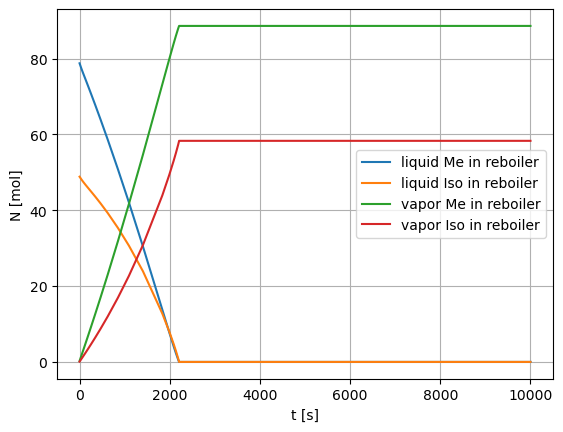

In [11]:
#plt.plot(tspan, N[:,0], label = 'liquid Me')
#plt.plot(tspan, N[:,1], label = 'liquid Iso')
#plt.plot(tspan, N[:,2], label = 'vapor Me')
#plt.plot(tspan, N[:,3], label = 'vapor Iso')

plt.plot(sol.t, sol.y[0], label = 'liquid Me in reboiler')
plt.plot(sol.t, sol.y[1], label = 'liquid Iso in reboiler')
plt.plot(sol.t, sol.y[2], label = 'vapor Me in reboiler')
plt.plot(sol.t, sol.y[3], label = 'vapor Iso in reboiler')


plt.legend()
plt.xlabel("t [s]")
plt.ylabel("N [mol]")
plt.grid()
plt.show()

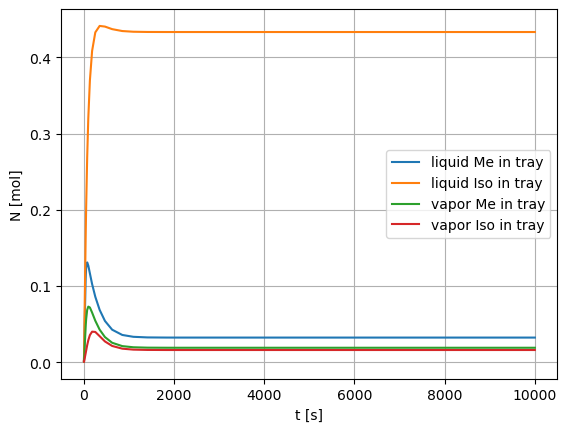

In [12]:
plt.plot(sol.t, sol.y[5], label = 'liquid Me in tray')
plt.plot(sol.t, sol.y[6], label = 'liquid Iso in tray')
plt.plot(sol.t, sol.y[7], label = 'vapor Me in tray')
plt.plot(sol.t, sol.y[8], label = 'vapor Iso in tray')

plt.legend()
plt.xlabel("t [s]")
plt.ylabel("N [mol]")
plt.grid()
plt.show()

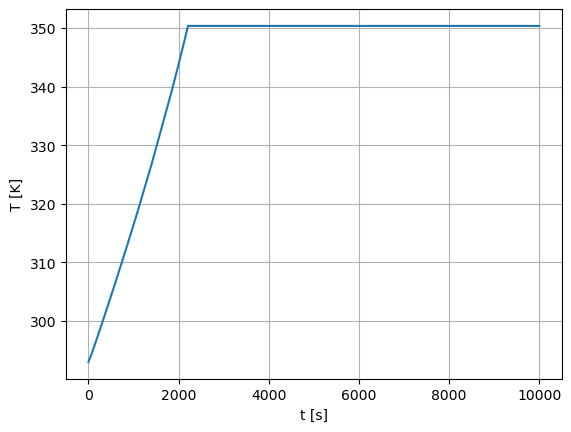

In [13]:
#plt.plot(tspan,N[:,4])
plt.plot(sol.t,sol.y[4])
plt.xlabel("t [s]")
plt.ylabel("T [K]")
plt.grid()
plt.show()

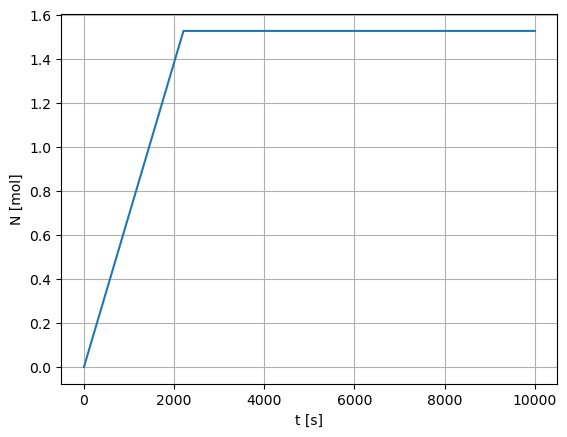

In [14]:
#plt.plot(tspan,N[:,4])
plt.plot(sol.t,sol.y[9], label='top product receiver')
plt.xlabel("t [s]")
plt.ylabel("N [mol]")
plt.grid()
plt.show()